### Importing libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

### Reading data, and knowing about it's basic info

In [2]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv")
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
print(f"rows, cols = {df.shape}")

rows, cols = (19104, 14)


In [4]:
df.dtypes.reset_index()

,index,0
0,Unnamed: 0,int64
1,MMM-YY,object
2,Driver_ID,int64
3,Age,float64
4,Gender,float64
5,City,object
6,Education_Level,int64
7,Income,int64
8,Dateofjoining,object
9,LastWorkingDate,object


In [5]:
def missing_data_info(df):
    missing_data = pd.DataFrame({
        "feature": df.columns.tolist(),
        "missing_count": df.isna().sum().values
    })

    missing_data["percentage"] = ((missing_data["missing_count"] / df.shape[0]) * 100).round(2)

    display(missing_data)

    print(f"\ntotal number of missing values = {df.isna().sum().sum()}")

missing_data_info(df)

,feature,missing_count,percentage
0,Unnamed: 0,0,0.00
1,MMM-YY,0,0.00
2,Driver_ID,0,0.00
3,Age,61,0.32
4,Gender,52,0.27
5,City,0,0.00
6,Education_Level,0,0.00
7,Income,0,0.00
8,Dateofjoining,0,0.00
9,LastWorkingDate,17488,91.54



total number of missing values = 17601


In [6]:
duplicated_count = df.duplicated().sum()
print(duplicated_count)

0


In [7]:
df.describe(include = "all")

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19104,19104.000000,19043.000000,19052.000000,19104,19104.000000,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000
unique,NaN,24,NaN,NaN,NaN,29,NaN,NaN,869,493,NaN,NaN,NaN,NaN
top,NaN,01/01/19,NaN,NaN,NaN,C20,NaN,NaN,23/07/15,29/07/20,NaN,NaN,NaN,NaN
freq,NaN,1022,NaN,NaN,NaN,1008,NaN,NaN,192,70,NaN,NaN,NaN,NaN
mean,9551.500000,NaN,1415.591133,34.668435,0.418749,NaN,1.021671,65652.025126,NaN,NaN,1.690536,2.252670,5.716621e+05,2.008899
std,5514.994107,NaN,810.705321,6.257912,0.493367,NaN,0.800167,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832
min,0.000000,NaN,1.000000,21.000000,0.000000,NaN,0.000000,10747.000000,NaN,NaN,1.000000,1.000000,-6.000000e+06,1.000000
25%,4775.750000,NaN,710.000000,30.000000,0.000000,NaN,0.000000,42383.000000,NaN,NaN,1.000000,1.000000,0.000000e+00,1.000000
50%,9551.500000,NaN,1417.000000,34.000000,0.000000,NaN,1.000000,60087.000000,NaN,NaN,1.000000,2.000000,2.500000e+05,2.000000
75%,14327.250000,NaN,2137.000000,39.000000,1.000000,NaN,2.000000,83969.000000,NaN,NaN,2.000000,3.000000,6.997000e+05,3.000000


##### Summary:
1. there are 14 features (one label class) and 19104 data points -> which is needed to be cleaned, splitted and trained/validated.
2. there are few date features which are present in object data type -> this can be converted into pd.to_datetime and some insights can be derived
3. missing values are present in age, gender, LastWorkingDay
    - age, gender can be removed (only few missing points) or use KNNImputer to impute
    - LastWorkingDay might be the target class -> let's check later
4. no duplicated data
5. this data is from 29 cities

### Data cleaning and Data Preparation

In [49]:
df_copy = df.copy()

In [51]:
df_copy.dropna(subset = ["Gender"], inplace = True)
# df_copy.drop("Unnamed: 0", axis = 1, inplace = True)

numerical_columns = df_copy.select_dtypes(include=['float64', 'int64']).columns

knn_imputer = KNNImputer(n_neighbors = 5)
df_copy[numerical_columns] = knn_imputer.fit_transform(df_copy[numerical_columns])
display(df_copy.sample(5))

missing_data_info(df_copy)


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
11327,11327.0,03/01/20,1678.0,33.0,0.0,C16,0.0,41305.0,29/11/17,NaN,2.0,2.0,200000.0,1.0
9156,9156.0,07/01/19,1354.0,34.0,1.0,C20,2.0,54212.0,10/09/18,NaN,2.0,3.0,249870.0,1.0
14613,14613.0,11/01/19,2179.0,31.0,1.0,C22,1.0,59105.0,25/04/16,NaN,1.0,2.0,484370.0,3.0
15395,15395.0,05/01/19,2271.0,38.0,0.0,C2,0.0,55943.0,28/07/18,NaN,1.0,2.0,0.0,1.0
1538,1538.0,09/01/19,228.0,45.0,0.0,C6,2.0,53385.0,25/07/16,NaN,1.0,1.0,1015500.0,3.0


,feature,missing_count,percentage
0,Unnamed: 0,0,0.00
1,MMM-YY,0,0.00
2,Driver_ID,0,0.00
3,Age,0,0.00
4,Gender,0,0.00
5,City,0,0.00
6,Education_Level,0,0.00
7,Income,0,0.00
8,Dateofjoining,0,0.00
9,LastWorkingDate,17441,91.54



total number of missing values = 17441


In [52]:
date_cols = [col for col in df_copy.columns if df_copy[col].dtype == "O" and col != "City"]

for col in date_cols:
    df_copy[col] = pd.to_datetime(df_copy[col])

In [78]:
modified_df = df_copy.groupby("Driver_ID").agg({"Income": "mean", "Total Business Value": "mean"}).reset_index()

In [79]:
# cols = ["Age", "Gender", "City", "Education_Level", "Grade", "Quarterly Rating", "Dateofjoining", "Joining Designation"]
# modified_cols = []

# for col in cols:
#     data_change_check = df_copy.groupby(by = "Driver_ID")[col].agg("nunique").reset_index().rename({col : "unique_count"}, axis = 1)
#     if data_change_check[data_change_check["unique_count"] > 1].shape[0] > 0:
#         modified_cols.append(col)

# print(modified_cols)

# for age, grade, rating we can take current values -> max(age, grade, quarterly rating)
feature_method = {
    "City": "max", 
    "Education_Level": "max", 
    "Dateofjoining": "max", 
    "Joining Designation": "max",
    "Age" : "max", 
    "Grade" : "max", 
    "Quarterly Rating" : "max",
    "Gender" : "max"
}

remaining_data = df_copy.groupby(by = "Driver_ID").agg(feature_method).reset_index()
modified_df = modified_df.merge(remaining_data, on = "Driver_ID", how = "inner")
modified_df.head()


,Driver_ID,Income,Total Business Value,City,Education_Level,Dateofjoining,Joining Designation,Age,Grade,Quarterly Rating,Gender
0,1.0,57387.0,571860.0,C23,2.0,2018-12-24,1.0,28.0,1.0,2.0,0.0
1,2.0,67016.0,0.0,C7,2.0,2020-11-06,2.0,31.0,2.0,1.0,0.0
2,4.0,65603.0,70000.0,C13,2.0,2019-12-07,2.0,43.0,2.0,1.0,0.0
3,5.0,46368.0,40120.0,C9,0.0,2019-01-09,1.0,29.0,1.0,1.0,0.0
4,6.0,78728.0,253000.0,C11,1.0,2020-07-31,3.0,31.0,3.0,2.0,1.0


### EDA

In [83]:
print(f"total number of unique drivers = {df['Driver_ID'].nunique()}")

total number of unique drivers = 2381


,Income,Total Business Value
City,,
C13,62173.028120,796263.075571
C29,67847.282222,736637.511111
C12,71676.976616,667282.310867
C26,67186.544304,661837.445339
C5,74745.911585,634855.975610
C16,63141.394922,632585.712271
C19,70735.860104,630978.151986


<Axes: xlabel='City'>

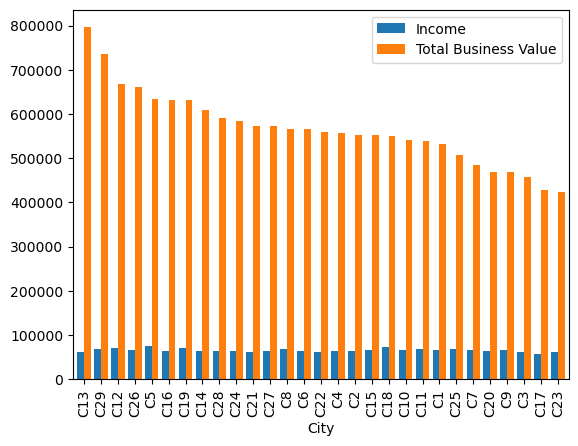

In [55]:
cities_income = df.groupby(by = "City").agg({"Income" : "mean", "Total Business Value" : "mean"}).sort_values(by = ["Total Business Value", "Income"], ascending = False)
display(cities_income.iloc[0:7, :])

cities_income.plot(kind = "bar", position = 0.5, width = 0.8)

<Axes: xlabel='Education_Level'>

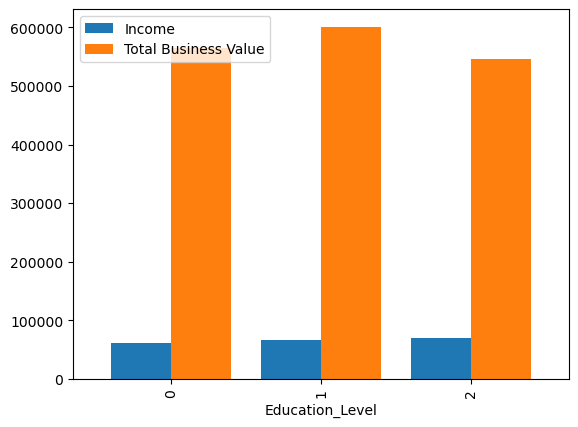

In [63]:
df.groupby(by = "Education_Level").agg({"Income" : "mean", "Total Business Value" : "mean"}).plot(kind = "bar", position = 0.5, width = 0.8)